Retrain TFLite Object Detector based on EfficientDet model. Original colab notebook with instructions on how to do it can be found [here](https://github.com/google-coral/tutorials/blob/master/retrain_efficientdet_model_maker_tf2.ipynb)

**Note:** As of 2021.10.18 it is crucial to install **tensorflow 2.5.0** because in 2.6.0 tflite model is changed and is not compatible with ObjectDetector under [TFLite Task library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) since the output order is changed. See more [here](https://discuss.tensorflow.org/t/invalidargumenterror-required-broadcastable-shapes-op-mul/3824/32).

In [1]:
!pip install -q tensorflow==2.5.0 tflite-model-maker pycocotools

Import libraries needed to run the code

In [1]:
import numpy as np
import os
from PIL import Image

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

print(tf.__version__)
print(tf.config.list_physical_devices())

2021-10-20 08:41:58.610326: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2021-10-20 08:42:03.368330: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-20 08:42:04.690242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 08:42:04.690707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.702GHz coreCount: 30 deviceMemorySize: 5.81GiB deviceMemoryBandwidth: 312.97GiB/s
2021-10-20 08:42:04.690769: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-10-20 08:42:04.743423: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-20 08:42:04.743585: I tensorflow/stream_e

In [3]:
MAX_FACES_PER_IMAGE=25 # How many faces can be in one image (= Maximum bounding boxes)
MODELS_DIR = 'models'
MODEL_FILE = 'efficientdet-lite0-wider.tflite'
LABELS_FILE = 'face-labels.txt'

# Download and prepare WIDER dataset

Download [WIDER](http://yjxiong.me/event_recog/WIDER/) (Web Image Dataset for Event Recognition) dataset. Download link is taken from challenge page [here](http://shuoyang1213.me/WIDERFACE/). I have two versions of downloaders here: first to run from Google Colab. Second is my own MinIO server. I have downloaded zip files and relocated to my self-hosted S3 bucket.

### Google Colab version

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from urllib import request

gdd.download_file_from_google_drive(file_id='1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q',
                                    dest_path='./WIDER_val.zip')  


gdd.download_file_from_google_drive(file_id='15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M',
                                    dest_path='./WIDER_train.zip')

request.urlretrieve('http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip', 'wider_face_split.zip')  

### Non Google Colab version (my S3 bucket)

In [ ]:
!pip install -q awscli
%env AWS_URL=https://sebi.ftp.sh
!aws --no-sign-request --endpoint-url ${AWS_URL} s3 cp s3://wider/wider_face_split.zip .
!aws --no-sign-request --endpoint-url ${AWS_URL} s3 cp s3://wider/WIDER_train.zip .
!aws --no-sign-request --endpoint-url ${AWS_URL} s3 cp s3://wider/WIDER_val.zip .

### Pre-process downloaded data

Unzip files

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('WIDER_val.zip')
zip_ref.extractall()
zip_ref.close()
os.unlink('WIDER_val.zip')

zip_ref = zipfile.ZipFile('WIDER_train.zip')
zip_ref.extractall()
zip_ref.close()
os.unlink('WIDER_train.zip')

zip_ref = zipfile.ZipFile('wider_face_split.zip')
zip_ref.extractall()
zip_ref.close()
os.unlink('wider_face_split.zip')

Create CSV annotations for DataLoader. First I tried to convert it to PASCAL VOC format using [this](https://github.com/akofman/wider-face-pascal-voc-annotations/blob/master/convert.py) repository. But TFLite DataLoader refused to create proper datasets. So I have adapted the script to create CSV file.

In [3]:
def parseImFilename(imFilename, imPath):
    im = Image.open(os.path.join(imPath, imFilename))
    width, height = im.size
    return width, height

def parseAnnotations(annotationsPath, targetCSV, imPath, dataset: str, maxBndBoxes: int = 25):
    csv = open(targetCSV, 'a')
    with open(annotationsPath) as f:
        while True:
            imFilename = f.readline().strip()
            if imFilename:
                width, height = parseImFilename(imFilename, imPath)
                nbBndboxes = int(f.readline())
                if maxBndBoxes < nbBndboxes:
                    print(f"{imFilename} has more bounding boxes ({nbBndboxes}) than maximum ({maxBndBoxes})")
                    for i in range(nbBndboxes):
                        f.readline()
                    continue
                
                i = 0
                if nbBndboxes > 0:
                    while i < nbBndboxes:
                        i = i + 1
                        x1, y1, w, h, _, _, _, _, _, _ = [int(i) for i in f.readline().split()]
                        csv.write(f"{dataset},{imPath}/{imFilename},face,{float(x1)/width},{float(y1)/height},,,{float(x1+w)/width},{float(y1+h)/height},,\n")
                else:
                    csv.write(f"{dataset},{imPath}/{imFilename},,0,0,,,0,0,,\n")
                    f.readline()
            else:
                break 
    f.close()

def parseFileList(annotationsPath, targetCSV, imPath, dataset: str):
    csv = open(targetCSV, 'a')
    with open(annotationsPath) as f:
        while True:
            imFilename = f.readline().strip()
            if imFilename:
                csv.write(f"{dataset},{imPath}/{imFilename},,0,0,,,0,0,,\n")
                print('{}'.format(imFilename))
            else:
                break 
    f.close()

if os.path.isfile('widerface.csv'):
    os.unlink('widerface.csv')
parseAnnotations('./wider_face_split/wider_face_train_bbx_gt.txt', 'widerface.csv', './WIDER_train/images', 'TRAIN', MAX_FACES_PER_IMAGE)
parseAnnotations('./wider_face_split/wider_face_val_bbx_gt.txt', 'widerface.csv', './WIDER_val/images', 'VALIDATION', MAX_FACES_PER_IMAGE)

0--Parade/0_Parade_marchingband_1_778.jpg has more bounding boxes (35) than maximum (25)
0--Parade/0_Parade_marchingband_1_205.jpg has more bounding boxes (65) than maximum (25)
0--Parade/0_Parade_Parade_0_106.jpg has more bounding boxes (40) than maximum (25)
0--Parade/0_Parade_Parade_0_476.jpg has more bounding boxes (35) than maximum (25)
0--Parade/0_Parade_marchingband_1_579.jpg has more bounding boxes (121) than maximum (25)
0--Parade/0_Parade_Parade_0_782.jpg has more bounding boxes (30) than maximum (25)
0--Parade/0_Parade_Parade_0_325.jpg has more bounding boxes (418) than maximum (25)
0--Parade/0_Parade_Parade_0_136.jpg has more bounding boxes (80) than maximum (25)
0--Parade/0_Parade_marchingband_1_193.jpg has more bounding boxes (30) than maximum (25)
0--Parade/0_Parade_Parade_0_156.jpg has more bounding boxes (27) than maximum (25)
0--Parade/0_Parade_marchingband_1_631.jpg has more bounding boxes (54) than maximum (25)
0--Parade/0_Parade_marchingband_1_624.jpg has more boun

# Model EfficientDet Lite

Now load EfficientDet Lite model specs

In [3]:
spec = object_detector.EfficientDetLite0Spec()

2021-10-20 08:42:29.664363: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-20 08:42:29.665476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 08:42:29.665859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.702GHz coreCount: 30 deviceMemorySize: 5.81GiB deviceMemoryBandwidth: 312.97GiB/s
2021-10-20 08:42:29.666026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative 

Create DataLoader for training and validation data

In [4]:
train_data, validation_data, _ = object_detector.DataLoader.from_csv('./widerface.csv')
print(f"Train dataset length: {train_data.__len__()}\nValidation dataset length: {validation_data.__len__()}")

Train dataset length: 11604
Validation dataset length: 2931


## Train the model

In [5]:
# Now create and fine-tune the model. It will take some time...
model = object_detector.create(train_data=train_data,
                               model_spec=spec,
                               epochs=50,
                               batch_size=10,
                               train_whole_model=True)

2021-10-20 08:51:18.391948: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-20 08:51:18.416489: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3195045000 Hz


Epoch 1/50


2021-10-20 08:51:37.179463: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-10-20 08:51:39.836102: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8204
2021-10-20 08:51:42.138976: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-20 08:51:44.114381: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


1160/1160 [==============================] - 263s 203ms/step - det_loss: 0.7565 - cls_loss: 0.3725 - box_loss: 0.0077 - reg_l2_loss: 0.0638 - loss: 0.8204 - learning_rate: 0.0102 - gradient_norm: 3.0257
Epoch 2/50
1160/1160 [==============================] - 234s 202ms/step - det_loss: 0.5850 - cls_loss: 0.2967 - box_loss: 0.0058 - reg_l2_loss: 0.0654 - loss: 0.6504 - learning_rate: 0.0125 - gradient_norm: 2.4613
Epoch 3/50
1160/1160 [==============================] - 236s 203ms/step - det_loss: 0.5490 - cls_loss: 0.2807 - box_loss: 0.0054 - reg_l2_loss: 0.0667 - loss: 0.6157 - learning_rate: 0.0124 - gradient_norm: 2.2611
Epoch 4/50
1160/1160 [==============================] - 234s 202ms/step - det_loss: 0.5274 - cls_loss: 0.2699 - box_loss: 0.0052 - reg_l2_loss: 0.0676 - loss: 0.5951 - learning_rate: 0.0123 - gradient_norm: 2.1123
Epoch 5/50
1160/1160 [==============================] - 234s 202ms/step - det_loss: 0.5064 - cls_loss: 0.2647 - box_loss: 0.0048 - reg_l2_loss: 0.0684 - lo

In [6]:
model.export(export_dir=MODELS_DIR, export_format=ExportFormat.SAVED_MODEL)

2021-10-20 12:07:59.858347: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Evaluate

Now we evaluate trained model on validation data from WIDER dataset.

In [7]:
model.evaluate(validation_data)

2021-10-20 19:18:35.627906: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-20 19:18:35.627972: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


45/46 [============================>.] - ETA: 0s

2021-10-20 19:18:56.723850: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-20 19:18:56.723910: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


46/46 [==============================] - 34s 466ms/step



{'AP': 0.32231683,
 'AP50': 0.59710836,
 'AP75': 0.3228995,
 'APs': 0.05214,
 'APm': 0.4349696,
 'APl': 0.68017805,
 'ARmax1': 0.12616165,
 'ARmax10': 0.34255138,
 'ARmax100': 0.4114827,
 'ARs': 0.14037396,
 'ARm': 0.5411841,
 'ARl': 0.7488106,
 'AP_/face': 0.32231683,
 'AP_/': -1.0}

In [8]:
model.export(export_dir=MODELS_DIR,
             tflite_filename=MODEL_FILE,
             label_filename=LABELS_FILE,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

2021-10-20 19:23:26.333910: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2021-10-20 19:23:31.323877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2021-10-20 19:23:31.323914: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2021-10-20 19:23:31.323920: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored change_concat_input_ranges.
2021-10-20 19:23:31.328334: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: /tmp/tmp8grsaqkg
2021-10-20 19:23:31.398649: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-10-20 19:23:31.398688: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp8grsaqkg
2021-10-20 19

## Evaluate the TF Lite model

Exporting the model to TensorFlow Lite can affect the model accuracy, due to the reduced numerical precision from quantization and because the original TensorFlow model uses per-class non-max supression (NMS) for post-processing, while the TF Lite model uses global NMS, which is faster but less accurate.

Therefore you should always evaluate the exported TF Lite model and be sure it still meets your requirements:

In [9]:
model.evaluate_tflite(f'{MODELS_DIR}/{MODEL_FILE}', validation_data)

2931/2931 [==============================] - 4101s 1s/step



{'AP': 0.31365263,
 'AP50': 0.58680147,
 'AP75': 0.31146508,
 'APs': 0.047928076,
 'APm': 0.41867256,
 'APl': 0.67071307,
 'ARmax1': 0.12458462,
 'ARmax10': 0.33413827,
 'ARmax100': 0.3731836,
 'ARs': 0.11395429,
 'ARm': 0.48965126,
 'ARl': 0.71629953,
 'AP_/face': 0.31365263,
 'AP_/': -1.0}

### Test it on a new image


Just to be sure of things, let's run an inference with the TF Lite model ourselves. 
To simplify our code, we'll use the [PyCoral API](https://coral.ai/docs/reference/py/):

In [2]:
!pip install -q --extra-index-url https://google-coral.github.io/py-repo/ pycoral

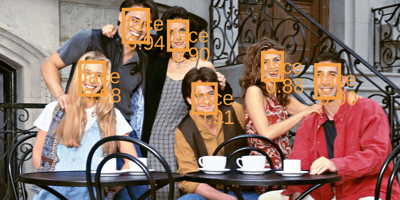

In [5]:
# Download the test image files
DOWNLOAD_URL = "https://static0.thethingsimages.com/wordpress/wp-content/uploads/2020/11/Friends-Season-1-cast.jpg"
INPUT_IMAGE = 'image.jpg'
!wget -q -O $INPUT_IMAGE $DOWNLOAD_URL

DETECTION_THRESHOLD = 0.4

import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                   outline=color, width=15)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size=90)
    draw.text((bbox.xmin + 20, bbox.ymin + 20),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color, font=font)

# Load the TF Lite model
labels = read_label_file(f'{MODELS_DIR}/{LABELS_FILE}')
interpreter = tflite.Interpreter(f'{MODELS_DIR}/{MODEL_FILE}')
interpreter.allocate_tensors()

# Resize the image
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference and draw boxes
interpreter.invoke()
objs = detect.get_objects(interpreter, DETECTION_THRESHOLD, scale)
draw_objects(ImageDraw.Draw(image), objs, labels)

# Show the results
width = 400
height_ratio = image.height / image.width
image.resize((width, int(width * height_ratio)))

## Compile model to run on Edge TPU

First we need to download the Edge TPU Compiler. Unfortunately it can be run only on Debian-based linux. If you are not running one you have the following options:
- You can use web coral-based compiler [here](https://colab.research.google.com/github/google-coral/tutorials/blob/master/compile_for_edgetpu.ipynb).
- Use docker image like [this](https://github.com/tomassams/docker-edgetpu-compiler) one.

If you have Debian-based OS run code below.

! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler

Before compiling the `.tflite` file for the Edge TPU, it's important to consider whether your model will fit into the Edge TPU memory. 

The Edge TPU has approximately 8 MB of SRAM for [caching model paramaters](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching), so any model close to or over 8 MB will not fit onto the Edge TPU memory. That means the inference times are longer, because some model parameters must be fetched from the host system memory.

One way to elimiate the extra latency is to use [model pipelining](https://coral.ai/docs/edgetpu/pipeline/), which splits the model into segments that can run on separate Edge TPUs in series. This can significantly reduce the latency for big models.

The following table provides recommendations for the number of Edge TPUs to use with each EfficientDet-Lite model.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

If you need extra Edge TPUs for your model, then update `NUMBER_OF_TPUS` here:

NUMBER_OF_TPUS =  1
!edgetpu_compiler efficientdet-lite-salads.tflite -d --num_segments=$NUMBER_OF_TPUS

**Beware when using multiple segments:** The Edge TPU Comiler divides the model such that all segments have roughly equal amounts of parameter data, but that does not mean all segments have the same latency. Especially when dividing an SSD model such as EfficientDet, this results in a latency-imbalance between segments, because SSD models have a large post-processing op that actually executes on the CPU, not on the Edge TPU. So although segmenting your model this way is better than running the whole model on just one Edge TPU, we recommend that you segment the EfficientDet-Lite model using our [profiling-based partitioner tool](https://github.com/google-coral/libcoral/tree/master/coral/tools/partitioner#profiling-based-partitioner-for-the-edge-tpu-compiler), which measures each segment's latency on the Edge TPU and then iteratively adjusts the segmentation sizes to provide balanced latency between all segments.

### Download the files

In [ ]:
from google.colab import files
import os

files.download(f'{MODELS_DIR}/{MODEL_FILE}')
EDGETPU_MODEL, EXTENSION = os.path.splitext(MODEL_FILE)
files.download(f'{MODELS_DIR}/{EDGETPU_MODEL}_edgetpu{EXTENSION}')
files.download(f'{MODELS_DIR}/{LABELS_FILE}')